Epoch 0, Loss: 0.1401
Epoch 10, Loss: 0.0365
Epoch 20, Loss: 0.0225
Epoch 30, Loss: 0.0184
Epoch 40, Loss: 0.0175
Epoch 50, Loss: 0.0163
Epoch 60, Loss: 0.0148
Epoch 70, Loss: 0.0129
Epoch 80, Loss: 0.0111
Epoch 90, Loss: 0.0110


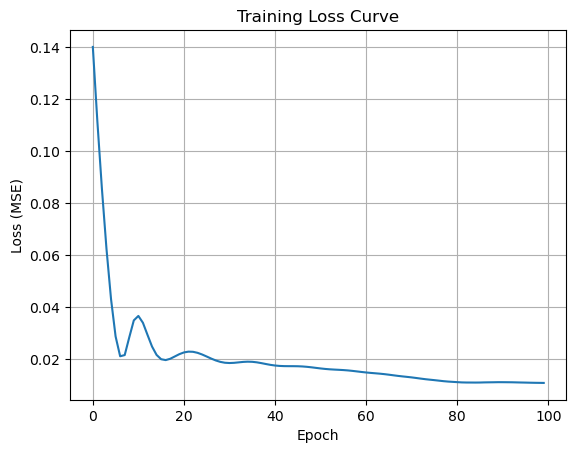

Mean Absolute Error: 1.95 °C


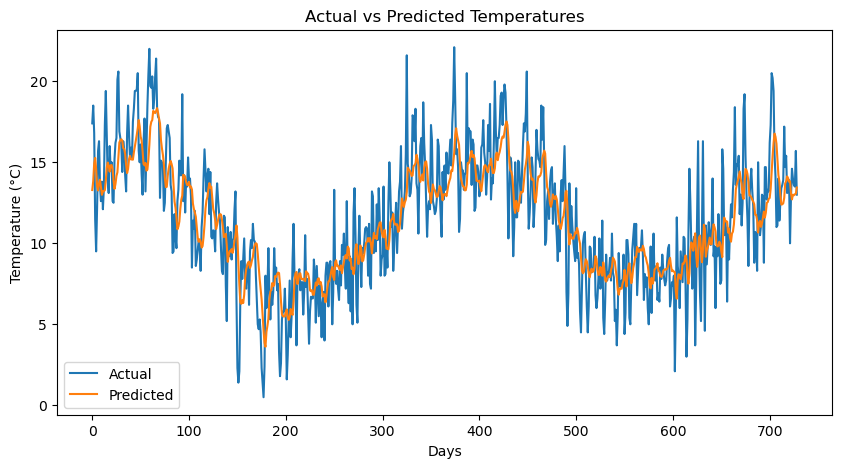

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)
temps = df["Temp"].values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
temps = scaler.fit_transform(temps)

# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 7
X, y = create_sequences(temps, SEQ_LEN)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output
        return out

model = RNNModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
losses = []
EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot loss curve
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()
    y_true = y_test.numpy()

# Inverse transform predictions
y_pred_inv = scaler.inverse_transform(y_pred)
y_true_inv = scaler.inverse_transform(y_true)

# MAE
mae = mean_absolute_error(y_true_inv, y_pred_inv)
print(f"Mean Absolute Error: {mae:.2f} °C")

# Actual vs Predicted plot
plt.figure(figsize=(10, 5))
plt.plot(y_true_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Temperatures")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.show()